In [79]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

import time
import sys

import sklearn

import forecast

import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa import *
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_predict

from statsmodels.iolib.table import SimpleTable
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from patsy import dmatrices

In [80]:
path = '/home/kei/Desktop/data/innostage/innostage_task_5/tsData.json'

In [81]:
ts_data = pd.read_json(path)
original_df = ts_data.rename(columns = {'cnt': 'count'})


In [82]:
mean_df = original_df['count'].resample('20Min').mean()

mean_df.index = pd.DatetimeIndex(mean_df.index).to_period('20Min')

<AxesSubplot: >

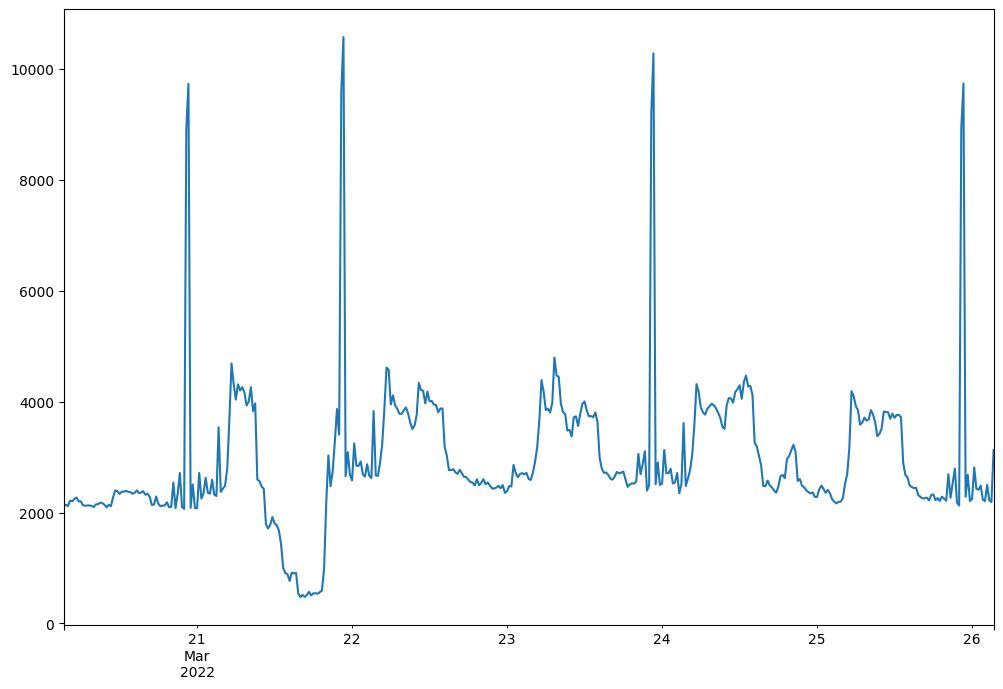

In [83]:
mean_df.plot(figsize = (12, 8))

<AxesSubplot: >

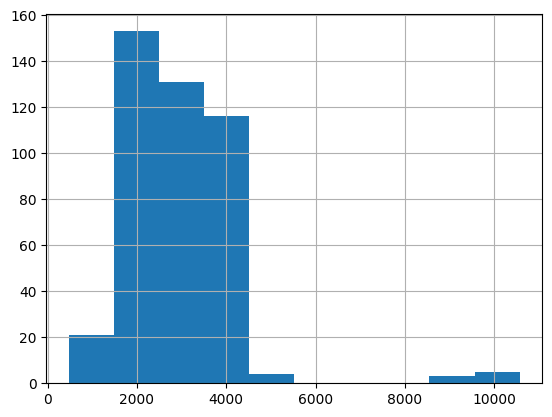

In [272]:
mean_df.hist()

In [90]:
stationarity_test_result = adfuller(mean_df.dropna())

print(f'adf-value: %.10f' % stationarity_test_result[0])
print('p-value: %.10f' % stationarity_test_result[1])
print(f'critical values {stationarity_test_result[4]}')


if stationarity_test_result[1] > 0.05:
    print('''
%.10f > 0.05
Нулевая гипотеза не отвергнута
Временной ряд не стационарен''' % stationarity_test_result[1])
    
else:
    print('''
%.10f < 0.05
Нулевая гипотеза отвергнута.
Временной ряд стационарен.
Порядок d равен 0''' % stationarity_test_result[1])

adf-value: -5.1094654442
p-value: 0.0000134174
critical values {'1%': -3.445721386098794, '5%': -2.868316661451884, '10%': -2.5703797268320376}

0.0000134174 < 0.05
Нулевая гипотеза отвергнута.
Временной ряд стационарен.
Порядок d равен 0


/home/kei/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


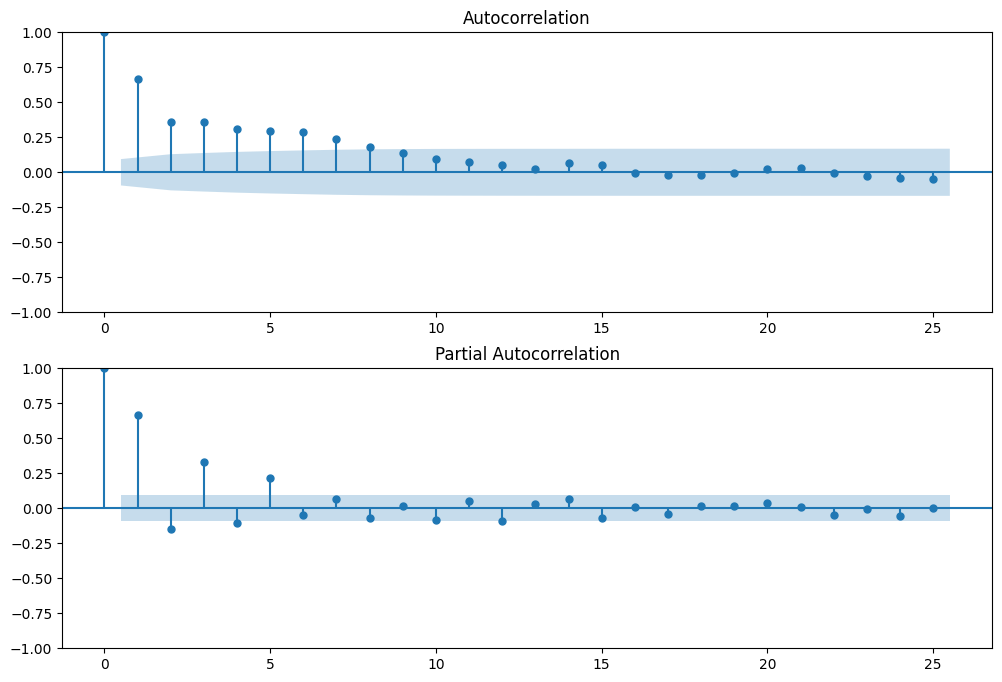

In [247]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(mean_df, lags = 25, ax = ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(mean_df, lags = 25, ax = ax2)

**q = 7  
p = 5  
d = 0**

In [371]:
model = ARIMA(mean_df, order = (5, 0, 4)).fit()

In [372]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  433
Model:                 ARIMA(5, 0, 4)   Log Likelihood               -3529.968
Date:                Wed, 22 Feb 2023   AIC                           7081.936
Time:                        14:59:27   BIC                           7126.714
Sample:                    03-20-2022   HQIC                          7099.612
                         - 03-26-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2947.6140    444.581      6.630      0.000    2076.251    3818.977
ar.L1          2.0512      0.160     12.832      0.000       1.738       2.365
ar.L2         -1.8839      0.255     -7.385      0.0

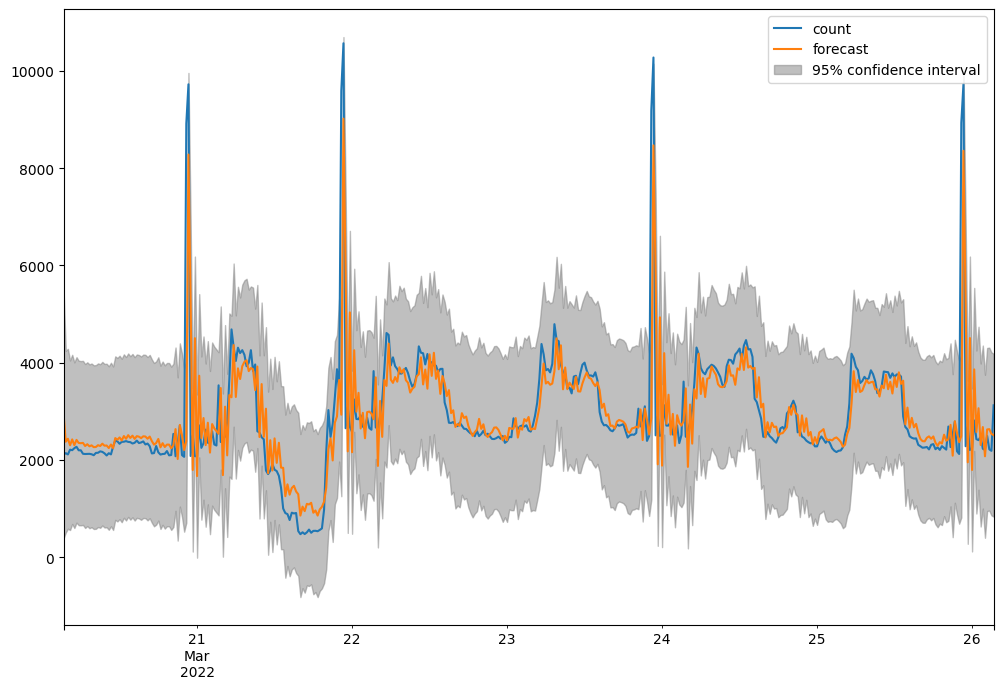

In [374]:
fig, ax = plt.subplots(figsize = (12, 8))

ax = mean_df.plot(ax=ax)

plot_predict(model, '2022-03-20', '2022-03-26', ax=ax, dynamic = False)

plt.show()

In [429]:
#EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

In [425]:
cleared_df = original_df.drop(original_df[original_df['count'] > 6000].index)
cleared_df = cleared_df.drop(cleared_df[cleared_df['count'] < 1500].index)

<AxesSubplot: >

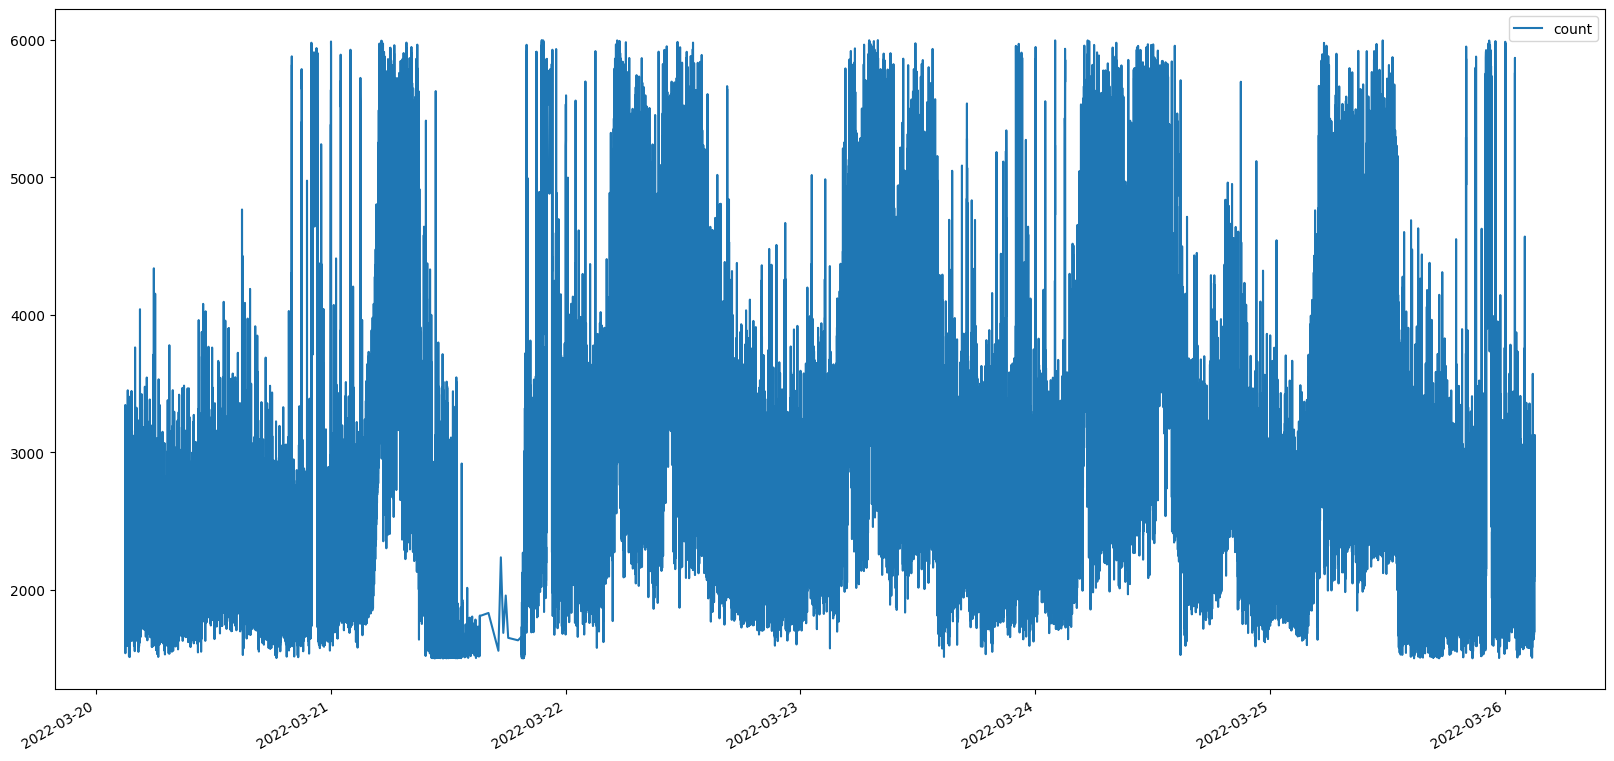

In [426]:
cleared_df.plot(figsize = (20, 10))

In [463]:
cleared_mean_df = cleared_df.resample('20Min').mean().dropna()
cleared_mean_df.index = pd.DatetimeIndex(cleared_mean_df.index).to_period('20Min')

<AxesSubplot: >

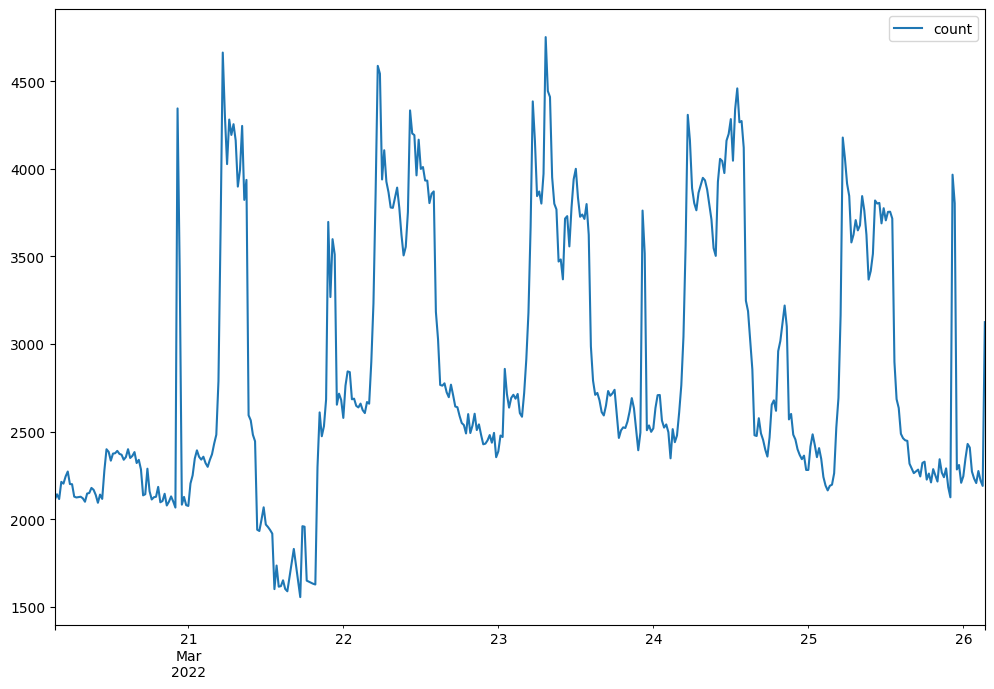

In [464]:
cleared_mean_df.plot(figsize = (12, 8))

In [465]:
if adfuller(cleared_mean_df)[1] > 0.05:
    print ('Ряд не стационарен')
else:
    print ('Ряд стационарен')

Ряд стационарен


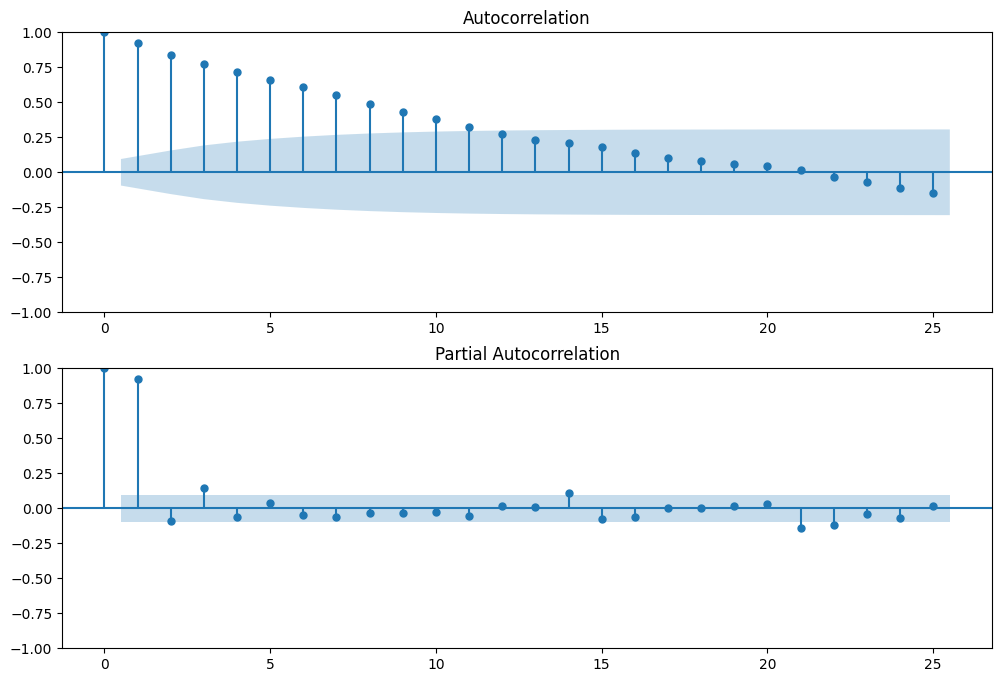

In [466]:
fig = plt.figure(figsize = (12, 8))

ax1 = fig.add_subplot(211)
fig = plot_acf(cleared_mean_df, lags = 25, ax=ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(cleared_mean_df, lags = 25, ax=ax2)

In [494]:
second_model = ARIMA(cleared_mean_df, order = (11, 0, 22)).fit()

In [495]:
print(second_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  427
Model:               ARIMA(11, 0, 22)   Log Likelihood               -2992.459
Date:                Wed, 22 Feb 2023   AIC                           6054.917
Time:                        16:30:38   BIC                           6196.905
Sample:                    03-20-2022   HQIC                          6111.000
                         - 03-26-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2872.6951    169.832     16.915      0.000    2539.831    3205.559
ar.L1          0.7802      0.654      1.194      0.233      -0.501       2.062
ar.L2          0.0561      1.024      0.055      0.9

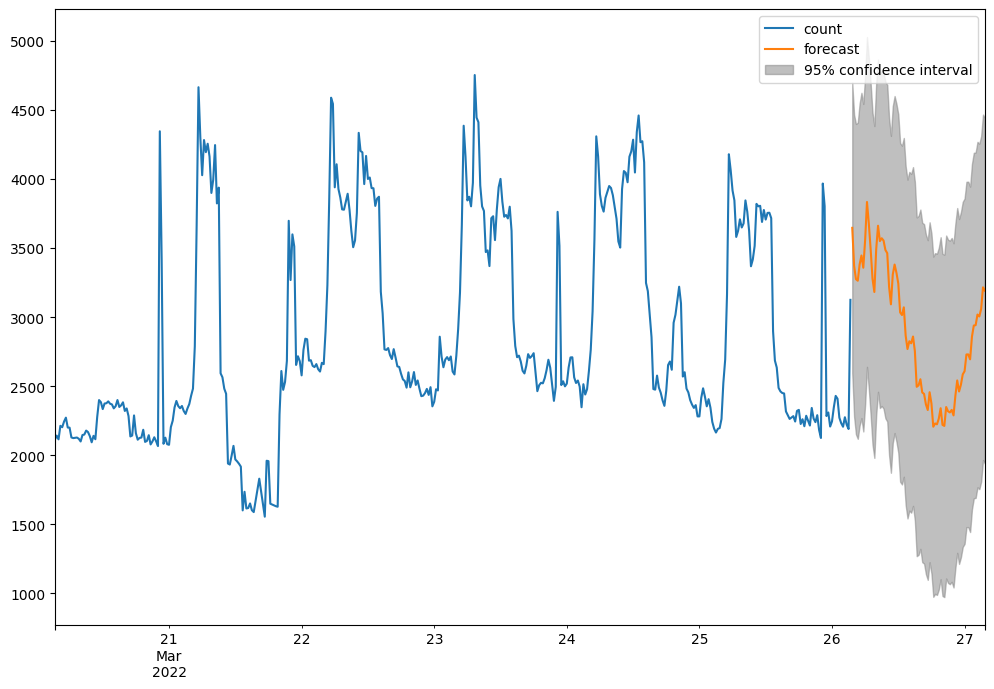

In [512]:
fig, ax = plt.subplots(figsize = (12, 8))

ax = cleared_mean_df.plot(ax=ax)

plot_predict(second_model, '2022-03-26 03:10:00 ', '2022-03-27 03:20:00', ax=ax, dynamic = False)

plt.show()

In [513]:
# Анализ остатков

In [534]:
myresiduals_1 = pd.DataFrame(model.resid)
myresiduals_2 = pd.DataFrame(second_model.resid)
plt.rcParams.update({'figure.figsize' :(12,5), 'figure.dpi' : 120})

In [1]:
fig, ax = plt.subplots(1,2) 
myresiduals_1.plot(title = "Residuals first model", ax = ax[0]) 
myresiduals_1.plot(kind = 'kde', title = 'Density first model', ax = ax[1]) 
plt.show()

NameError: name 'plt' is not defined

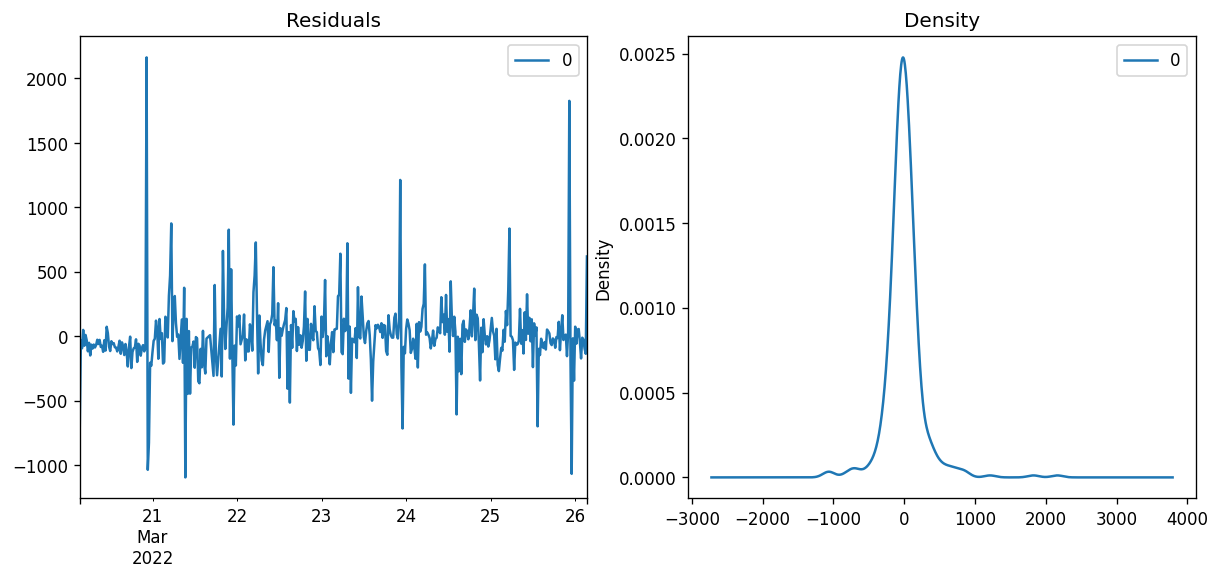

In [536]:
fig, ax = plt.subplots(1,2) 

myresiduals_2.plot(title = "Residuals second model", ax = ax[0]) 
myresiduals_2.plot(kind = 'kde', title = 'Density second model', ax = ax[1]) 
plt.show()